In [21]:
import sympy as sp
import rounding as rnd

In [14]:
# Create symbols

V_in, V_out, V_F = sp.symbols('V_in V_out V_F')
I_out, I_Rfb, I_sw_min, I_sw_max = sp.symbols('I_out I_Rfb I_sw_min I_sw_max')
R_fb = sp.symbols('R_fb')
P_out = sp.symbols('P_out')
t_off_min, t_on_min = sp.symbols('t_off_min t_on_min')
D, eta, N_ps = sp.symbols('D eta N_ps')
L_pri_min_off, L_pri_min_on = sp.symbols('L_pri_min_off L_pri_min_on')

In [94]:
# Immutable parameters (set by devices used)

LT8300 = [
    (I_Rfb, 100e-6), # Feedback regulation current, 100µA
    (I_sw_max, 260e-3), # Maximum switch current, 260mA
    (I_sw_min, 52e-3), # Minimum switch current limit, 52mA
    (t_off_min, 350e-9), # Minimum off time, 290ns
    (t_on_min, 160e-9), # Minimum on time, 160ns
]

LT8301 = [
    (I_Rfb, 100e-6), # Feedback regulation current, 100µA
    (I_sw_max, 1.2), # Maximum switch current, 1.2A
    (I_sw_min, 290e-3), # Minimum switch current limit, 290mA
    (t_off_min, 450e-9), # Minimum off time, 450ns
    (t_on_min, 170e-9), # Minimum on time, 170ns
]

Diode = [    
    (V_F, 1.45), # Output diode forward voltage, 1.45V
]

fixed = LT8300 + Diode

In [95]:
# Set up design equations

eq_V_out = sp.Eq(V_out, I_Rfb * (R_fb / N_ps) - V_F)

eq_D = sp.Eq(D, (V_out + V_F) * N_ps / ((V_out + V_F) * N_ps + V_in))

eq_P_out = sp.Eq(P_out, eta * V_in * D * I_sw_max * 0.5)

eq_L_pri_min_off = sp.Eq(L_pri_min_off, t_off_min * N_ps * (V_out + V_F) / I_sw_min)
eq_L_pri_min_on = sp.Eq(L_pri_min_on, t_on_min * V_in / I_sw_min)

In [136]:
from IPython.display import display, Markdown

# Fix relevant parameters and solve

V_out_value = 400

input_params = [
    (eta, 0.85), # ratio, Assumed efficiency
    (N_ps, 0.1), # ratio, Turns ratio
    (V_out, V_out_value), # V, output voltage
]

output = '''
V<sub>in</sub> | R<sub>fb</sub> | V<sub>out</sub> | L<sub>pri<sub>min</sub></sub> | D | P<sub>out</sub> | I<sub>out</sub>
-|-|-|-|-|-|-
'''

test_voltages = [1, 3.3, 5, 8, 10.8, 12, 15, 18, 21, 24, 26.4]
R_fb_values = []
V_out_values = []
L_pri_min_values = []
D_values = []
P_out_values = []
I_out_values = []

for V in test_voltages:
    knowns = input_params + [(V_in, V)]
    
    output = output + f'{rnd.prefix(V)}V'
    solution = sp.solve(eq_V_out.subs(knowns).subs(fixed), R_fb)
    R_fb_sol = rnd.closest_E_series_value(solution[0], 96, 'gt')
    output = output + f'|{rnd.prefix(R_fb_sol)}Ω'
    R_fb_values.append(R_fb_sol)

    knowns_2 = input_params[:-1] + [(V_in, V), (R_fb, R_fb_sol)]
    solution = sp.solve(eq_V_out.subs(knowns_2).subs(fixed), V_out)
    V_out_sol = solution[0]
    output = output + f'|{rnd.prefix(V_out_sol)}V'
    V_out_values.append(V_out_sol)
    
    solution_off = sp.solve(eq_L_pri_min_off.subs(knowns).subs(fixed), L_pri_min_off)
    solution_on = sp.solve(eq_L_pri_min_on.subs(knowns).subs(fixed), L_pri_min_on)
    L_pri_min = max(solution_off[0], solution_on[0])
    output = output + f'|{rnd.prefix(L_pri_min)}H'
    L_pri_min_values.append(L_pri_min)
    
    solution_D = sp.solve(eq_D.subs(knowns).subs(fixed), D)
    output = output + f'|{rnd.sig_figs(solution_D[0]*100,3)}%'
    D_values.append(solution_D)
    
    solution = sp.solve(eq_P_out.subs(knowns).subs(fixed).subs([(D, solution_D[0])]), P_out)
    P_out_sol = solution[0]
    output = output + f'|{rnd.prefix(P_out_sol)}W'
    P_out_values.append(P_out_sol)

    output = output + f'|{rnd.prefix(P_out_sol/V_out_sol)}A'
    I_out_values.append(P_out_sol/V_out_sol)

    output = output + '\n'

display(Markdown(output))

L = 15e-6



V<sub>in</sub> | R<sub>fb</sub> | V<sub>out</sub> | L<sub>pri<sub>min</sub></sub> | D | P<sub>out</sub> | I<sub>out</sub>
-|-|-|-|-|-|-
1V|402kΩ|400.55V|270.207µH|97.6%|107.814mW|269.166µA
3.3V|402kΩ|400.55V|270.207µH|92.4%|336.952mW|841.223µA
5V|402kΩ|400.55V|270.207µH|88.9%|491.308mW|1.22658mA
8V|402kΩ|400.55V|270.207µH|83.4%|737.11mW|1.84025mA
10.8V|402kΩ|400.55V|270.207µH|78.8%|940.407mW|2.34779mA
12V|402kΩ|400.55V|270.207µH|77.0%|1.02085W|2.54862mA
15V|402kΩ|400.55V|270.207µH|72.8%|1.20664W|3.01247mA
18V|402kΩ|400.55V|270.207µH|69.0%|1.37326W|3.42844mA
21V|402kΩ|400.55V|270.207µH|65.7%|1.52353W|3.8036mA
24V|402kΩ|400.55V|270.207µH|62.6%|1.65975W|4.14367mA
26.4V|402kΩ|400.55V|270.207µH|60.3%|1.75988W|4.39365mA


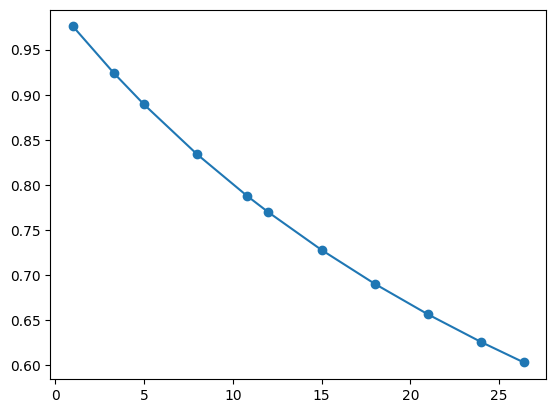

In [137]:
import matplotlib.pyplot as plt

plt.plot(test_voltages, D_values, marker='o')